<img src="https://upload.wikimedia.org/wikipedia/commons/a/a4/Eruption_1954_Kilauea_Volcano.jpg" width="500" height="500" />

# **Finding Volcanoes with CNN** <a id="0"></a> <br>

### Hello in this kernel we will try to classify the Magellan's Venus images and find the volcanoes with CNN.
#### **Content:**
* 1-[Load and Exploring the Data](#1)
    * a-[Fixing the Data](#2)
    * b-[Volcanoes With Graphs](#3)
* 2-[Print the Images](#4)
* 3-[The First Step to the CNN](#5)
    * a-[Prepare the Data for the CNN](#6)
    * b-[Building the First Model](#7)
    * c-[Train Our First Model](#8)
* 4-[Clearing the Data and Adding Dropouts](#9)
    * a-[Clearing the Data From Blank Images](#10)
    * b-[Building Improved Model With Dropouts](#11)
* 5-[Improving the Accuracy](#12)
    * a-[Image Data Generator](#13)
    * b-[More Layers and New Hyperparams](#14)
* 6-[Conclusion](#15)


## 1-Load and Exploring the Data [^](#0) <a id="1"></a> <br>
We have a lot of images which taken by Magellan spacecraft from Venus. Some of them belong to Venus volcanoes and our main task is the classification of them.

Okay let's start with load the data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

X_train = pd.read_csv('../input/volcanoes_train/train_images.csv')
y_train = pd.read_csv('../input/volcanoes_train/train_labels.csv')
X_test = pd.read_csv('../input/volcanoes_test/test_images.csv')
y_test = pd.read_csv('../input/volcanoes_test/test_labels.csv')

['Volcanoes_train', 'volcanoes_test', 'Volcanoes_test', 'volcanoes_train']


In [2]:
X_train.head()

95  101   99  103  95.1   ...    99.414  117.112  116.103  118.82  96.423
0   91   92   91   89    92   ...       105      104      100      90      81
1   87   70   72   74    84   ...        80       91       80      84      90
2    0    0    0    0     0   ...        90       92       80      88      96
3  114  118  124  119    95   ...       104      106      117     111     115
4   79   95   90   82    73   ...        71       62       97      89      73

[5 rows x 12100 columns]

In [3]:
y_train.head()

Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46               1.0
1         0   NaN     NaN               NaN
2         0   NaN     NaN               NaN
3         0   NaN     NaN               NaN
4         0   NaN     NaN               NaN

We have some labels in here. 
According to the dataset information first column tell us that the image has contain valcanoes or not.

Type column has 4 different value these are:
*Type: 1= definitely a volcano,2 =probably, 3= possibly, 4= only a pit is visible*

Radius: is the radius of the volcan in the center of the image, in pixels.

Number Volcanoes: The number of volcanoes in the image.**

So how many samples do we have?

In [4]:
print("X_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

X_train -> (6999, 12100) 
y_train -> (7000, 4) 
X_test -> (2733, 12100) 
y_test -> (2734, 4)


So we have 6999 flatten images that contain 12100 pixels in train set and 2733 in the test set.  So %28 of the data is test. The ratio is good so I will leave it same.

But we have some big problem here. For train data, we have 6999 images but in labels, we have 7000 labels so there must be one missing image.
### a) Fixing the Data [^](#0) <a id="2"></a> <br>

Actually, if you checked above the X_train.head part you will see clearly that the column names are our missing image's pixels. The problem is the indexing of the X_train and X_test and we must reindex this. 

There is also one more thing that we must solve. The column names are floating points and I don't know why :/ But we can turn them into an integer to use as pixels.

In [5]:
def XFix(X):
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # adding column names as a new row
    X.index = X.index + 1  # shifting index
    X.sort_index(inplace=True)  # sorting the index

XFix(X_train)
XFix(X_test)

In [6]:
print("X_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

X_train -> (7000, 12100) 
y_train -> (7000, 4) 
X_test -> (2734, 12100) 
y_test -> (2734, 4)


Now we solve the problem let's continue.

### b) Volcanoes With Graphs [^](#0) <a id="2"></a> <br>
In this part, we can try to analyze our data's features with our precious graph libraries :)

We can check out the distribution of data with some colored graphs.  I will use plotly for it.

In [7]:
import plotly
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

y_trainVolcanoCount = y_train[y_train["Volcano?"] == 1].shape[0]
y_testVolcanoCount = y_test[y_test["Volcano?"] == 1].shape[0]

y_trainNotVolcanoCount = y_train[y_train["Volcano?"] == 0].shape[0]
y_testNotVolcanoCount = y_test[y_test["Volcano?"] == 0].shape[0]

x = ['Train', 'Test']
y = [y_trainVolcanoCount, y_testVolcanoCount]
y2 = [y_trainNotVolcanoCount, y_testNotVolcanoCount]

trace1 = go.Bar(
    x=x,
    y=y,
    textposition = 'auto',
    name = 'Volcano',
    marker=dict(
        color='rgb(255,120,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

trace2 = go.Bar(
    x=x,
    y=y2,
    textposition = 'auto',
    name = 'Not Volcano',
    marker=dict(
        color='rgb(20,20,20)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data = [trace1,trace2]

layout = go.Layout(
    title='Train and Test Data Volcanoes Distribution',
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

We can clearly see that our data is unbalanced. I will leave it same for now.

Then let's plot another graph that shows us the Type column distribution.

In [8]:
y_trainTypeDefinitelyCount = y_train[y_train["Type"] == 1].shape[0]
y_testTypeDefinitelyCount = y_test[y_test["Type"] == 1].shape[0]

y_trainTypeProbablyCount = y_train[y_train["Type"] == 2].shape[0]
y_testTypeProbablyCount = y_test[y_test["Type"] == 2].shape[0]

y_trainTypePossiblyCount = y_train[y_train["Type"] == 3].shape[0]
y_testTypePossiblyCount = y_test[y_test["Type"] == 3].shape[0]

y_trainTypePitCount = y_train[y_train["Type"] == 4].shape[0]
y_testTypePitCount = y_test[y_test["Type"] == 4].shape[0]

x = ['Train', 'Test']
y = [y_trainTypeDefinitelyCount, y_testTypeDefinitelyCount]
y2 = [y_trainTypeProbablyCount, y_testTypeProbablyCount]
y3 = [y_trainTypePossiblyCount, y_testTypePossiblyCount]
y4 = [y_trainTypePitCount, y_testTypePitCount]

trace1 = go.Bar(
    x=x,
    y=y,
    textposition = 'auto',
    name = 'Definitely Volcano',
    marker=dict(
        color='rgb(255,0,0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5),
        ),
    opacity=0.9
)

trace2 = go.Bar(
    x=x,
    y=y2,
    textposition = 'auto',
    name = 'Probably Volcano',
    marker=dict(
        color='rgb(255,100,0)',
        line=dict(
            color='rgb(100,100,100)',
            width=1.5),
        ),
    opacity=0.7
)

trace3 = go.Bar(
    x=x,
    y=y3,
    textposition = 'auto',
    name = 'Possibly Volcano',
    marker=dict(
        color='rgb(255,240,0)',
        line=dict(
            color='rgb(200,200,200)',
            width=1.5),
        ),
    opacity=0.5
)

trace4 = go.Bar(
    x=x,
    y=y4,
    textposition = 'auto',
    name = 'Only Pit is Visible',
    marker=dict(
        color='rgb(200,200,200)',
        line=dict(
            color='rgb(255,255,255)',
            width=1.5),
        ),
    opacity=0.4
)

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(
    title='Train and Test Data Volcanoes Type Distribution',
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

The graph shows us the train and test data balanced but it is sad that we have just 140 images that definitely volcano from nearly 10000 images.

And now I will plot the *Number Volcanoes* column that will gives us the number of volcano in one image.

In [9]:
y_trainNumberVolcanoesOnelyCount = y_train[y_train["Number Volcanoes"] == 1].shape[0]
y_testNumberVolcanoesOneCount = y_test[y_test["Number Volcanoes"] == 1].shape[0]

y_trainNumberVolcanoesTwoCount = y_train[y_train["Number Volcanoes"] == 2].shape[0]
y_testNumberVolcanoesTwoCount = y_test[y_test["Number Volcanoes"] == 2].shape[0]

y_trainNumberVolcanoesThreeCount = y_train[y_train["Number Volcanoes"] == 3].shape[0]
y_testNumberVolcanoesThreeCount = y_test[y_test["Number Volcanoes"] == 3].shape[0]

y_trainNumberVolcanoesFourCount = y_train[y_train["Number Volcanoes"] >= 4].shape[0]
y_testNumberVolcanoesFourCount = y_test[y_test["Number Volcanoes"] >= 4].shape[0]

x = ['Train', 'Test']
y = [y_trainNumberVolcanoesOnelyCount, y_testNumberVolcanoesOneCount]
y2 = [y_trainNumberVolcanoesTwoCount, y_testNumberVolcanoesTwoCount]
y3 = [y_trainNumberVolcanoesThreeCount, y_testNumberVolcanoesThreeCount]
y4 = [y_trainNumberVolcanoesFourCount, y_testNumberVolcanoesFourCount]

trace1 = go.Bar(
    x=x,
    y=y,
    textposition = 'auto',
    name = 'One Volcano',
    marker=dict(
        color='rgb(212,123,231)',
        line=dict(
            color='rgb(0,0,0)',
            width=1.5),
        ),
    opacity=0.9
)

trace2 = go.Bar(
    x=x,
    y=y2,
    textposition = 'auto',
    name = 'Two Volcano',
    marker=dict(
        color='rgb(13,22,11)',
        line=dict(
            color='rgb(100,100,100)',
            width=1.5),
        ),
    opacity=0.7
)

trace3 = go.Bar(
    x=x,
    y=y3,
    textposition = 'auto',
    name = 'Three Volcano',
    marker=dict(
        color='rgb(0,240,0)',
        line=dict(
            color='rgb(200,200,200)',
            width=1.5),
        ),
    opacity=0.5
)

trace4 = go.Bar(
    x=x,
    y=y4,
    textposition = 'auto',
    name = 'Four or More Volcano',
    marker=dict(
        color='rgb(1,1,244)',
        line=dict(
            color='rgb(255,255,255)',
            width=1.5),
        ),
    opacity=0.4
)

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(
    title='Train and Test Data Volcanoes Type Distribution',
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Most of the images just include one volcano.

We have this information so far:
* Only %15 of images belongs to volcanoes.
* Even that %15 is labeled as volcanoes just %10 of them is definitely volcanoes.
* Most of the images just contain one volcano.

From now on we can check that the images.

## 2-Print Our Images [^](#0) <a id="4"></a> <br>

We work with graphs to understand more efficiently our data but we still don't know how Magellan's pictures look. To do this:
Firstly, I will deep copy the data to protect from changes.

In [10]:
y_train_copy = y_train.copy(deep=True)
X_train_copy = X_train.copy(deep=True)

Then we check again the shape of X_train.

In [11]:
X_train_copy.shape

(7000, 12100)

Resize the numpy arrays in here. I just translate the 7000 images 1D to 2D

In [12]:
X_train_copy = np.resize(X_train_copy, (7000, 110, 110))

![](http://i63.tinypic.com/jt3zpg.png)

Then I change the numerical values with their string equivalents.

In [13]:
y_train_copy.loc[y_train_copy["Type"] == 1, 'Type'] = "Definitely Volcano"
y_train_copy.loc[y_train_copy["Type"] == 2, 'Type'] = "Probably Volcano"
y_train_copy.loc[y_train_copy["Type"] == 3, 'Type'] = "Possibly Volcano"
y_train_copy.loc[y_train_copy["Type"] == 4, 'Type'] = "Only Pit is Visible"

y_train_copy.loc[y_train_copy["Volcano?"] == 0, 'Volcano?'] = "Not Volcano"
y_train_copy.loc[y_train_copy["Volcano?"] == 1, 'Volcano?'] = "Volcano"

y_train_copy.loc[y_train_copy["Number Volcanoes"] == 1, 'Number Volcanoes'] = "One Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 2, 'Number Volcanoes'] = "Two Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 3, 'Number Volcanoes'] = "Three or More Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 4, 'Number Volcanoes'] = "Three or More Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 5, 'Number Volcanoes'] = "Three or More Volcano"

Now we are ready to print them. I will print images categorically. To do this I use a printer function.

In [14]:
from matplotlib import pyplot as plt

def draw_images(feature):
    featureTypes = (y_train_copy.groupby([feature])[feature].nunique()).index
    f, ax = plt.subplots(len(featureTypes)*2, 5, figsize=(12,6*len(featureTypes)))
    for i in range(len(featureTypes)*2):
        typ = featureTypes[int(i/2)]
        sample = y_train_copy[y_train_copy[feature]==typ].sample(5)
        for j in range(5):
            imageIndex = sample.iloc[j].name
            image = X_train_copy[imageIndex]
            ax[i, j].imshow(image, resample=True)
            ax[i, j].set_title(typ, fontsize=13)
    plt.tight_layout()
    plt.show()

** Volcano?**

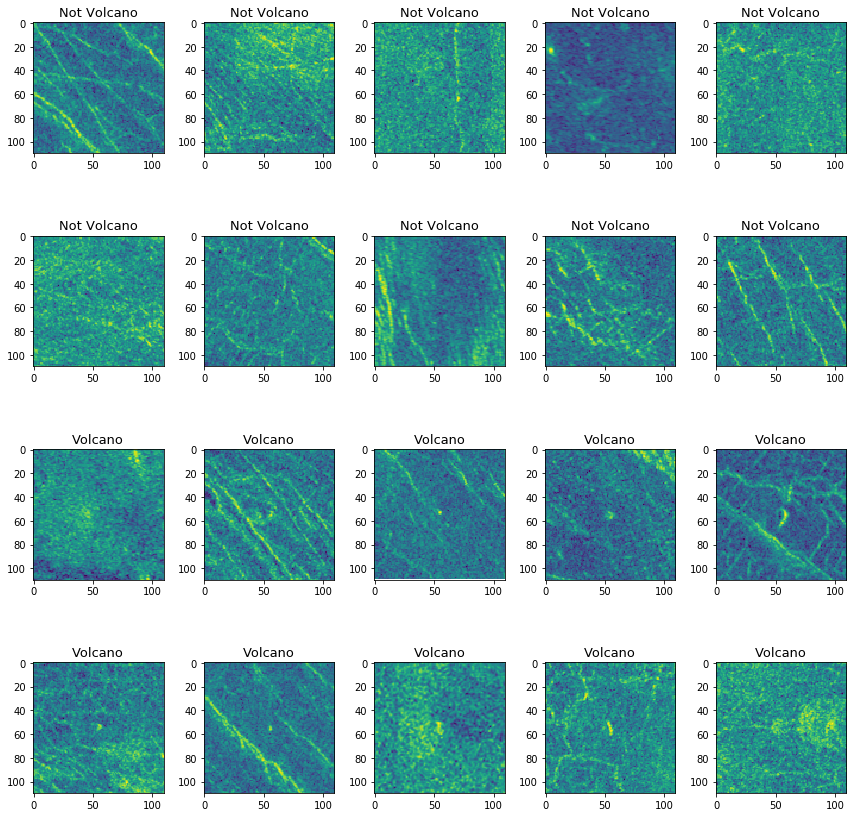

In [15]:
draw_images("Volcano?")

** Type **

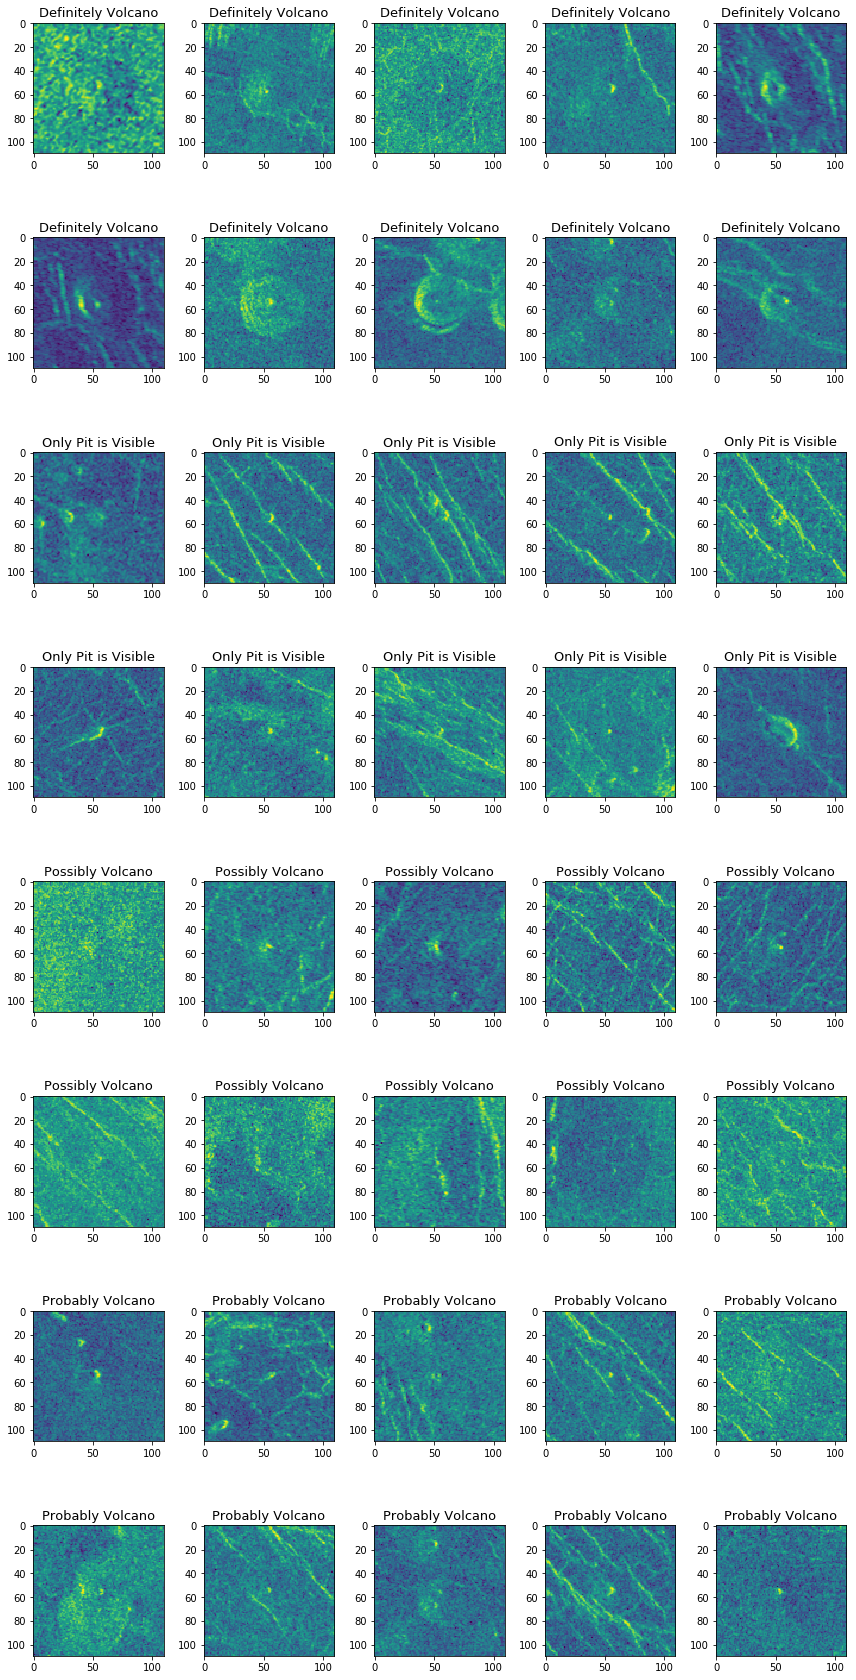

In [16]:
draw_images("Type")

** Number Volcanoes **

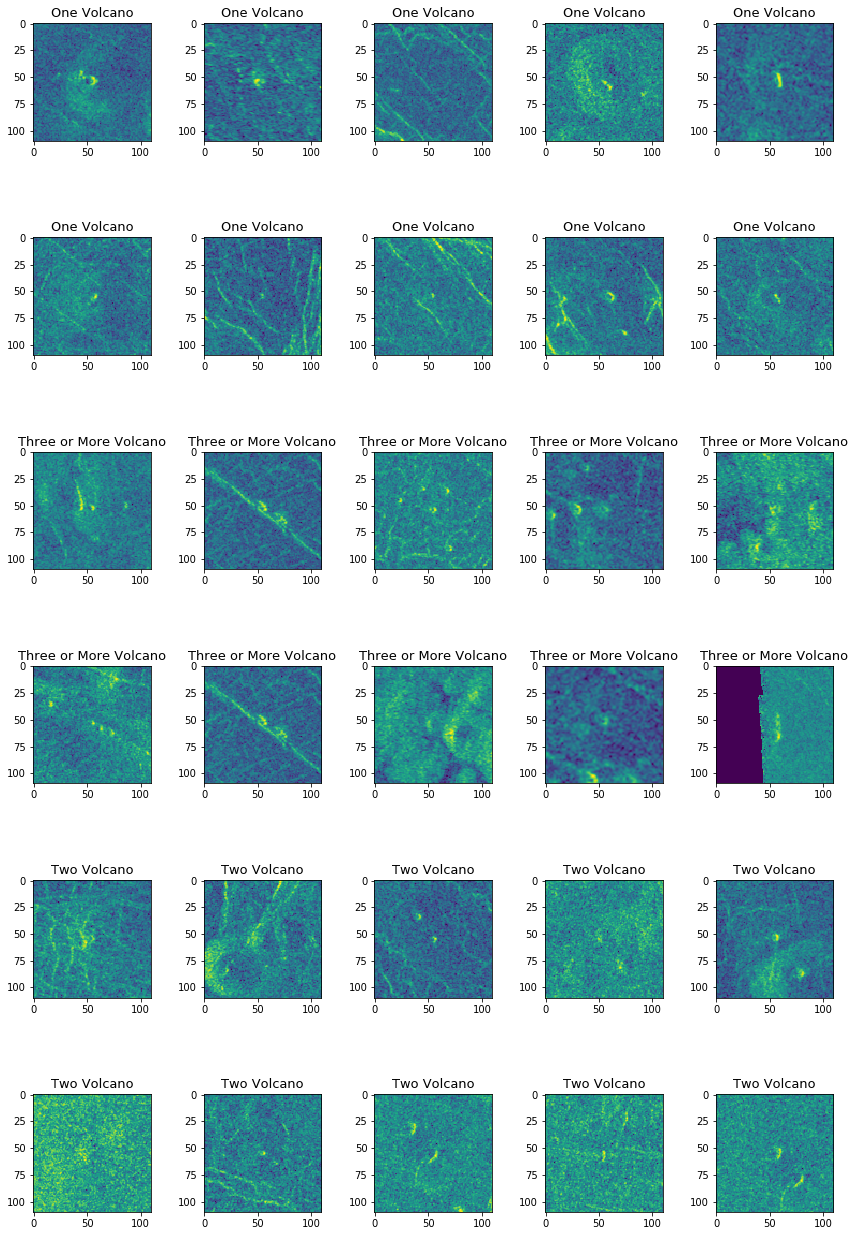

In [17]:
draw_images("Number Volcanoes")

We printed our images with their categories. I saw some images has black pixels and we need to clean them for better results but we don't do it now. Instead, we're going to start building the first CNN model.

## 3-The First Step to the CNN [^](#0) <a id="5"></a> <br>

After printing the images we can start to build our model But firstly we need to clean and prepare our data.

### a) Prepare the Data for the CNN [^](#0)<a id="6"></a> <br>
First, we need to split our test data to test and validation data. We will use %50 of test data as validation data. 
We use the validation data to understand that is there any overfitting problem in our model before testing with test data.

In [18]:
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

In [19]:
print("After split train data for valitadion data.")
print("%70   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n%15   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n%15   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

After split train data for valitadion data.
%70   X_train -> (7000, 12100) 
      y_train -> (7000, 4) 

%15   X_test -> (1367, 12100) 
      y_test -> (1367, 4) 

%15   X_val -> (1367, 12100) 
      y_val -> (1367, 4)


Second, we need to resize our X_test too like X_train we did before. And we need to add one more dimension both of them beacuse keras want it to know the color chanels of image.

In [20]:
print("Before resize")
print("%70   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n%15   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n%15   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

X_test = np.resize(X_test, (1367, 110, 110, 1))
X_train = np.resize(X_train, (7000, 110, 110, 1))
X_val = np.resize(X_val, (1367, 110, 110, 1))

print("\nAfter resize")
print("%70   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n%15   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n%15   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

Before resize
%70   X_train -> (7000, 12100) 
      y_train -> (7000, 4) 

%15   X_test -> (1367, 12100) 
      y_test -> (1367, 4) 

%15   X_val -> (1367, 12100) 
      y_val -> (1367, 4)

After resize
%70   X_train -> (7000, 110, 110, 1) 
      y_train -> (7000, 4) 

%15   X_test -> (1367, 110, 110, 1) 
      y_test -> (1367, 4) 

%15   X_val -> (1367, 110, 110, 1) 
      y_val -> (1367, 4)


Third, we need to drop the *Type, Radius, Number Volcanoes* columns from output data. Remember that we just want to label the images that volcano or not.

In [21]:
y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]
y_val = y_val["Volcano?"]

Four, we need to normalize our pixels from 0-255 to 0-1. But why we do this? 

The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.

In [22]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

And last we need to change our data's shape again but this time we just change our labels. See the pic below. We name this operation as One Hot Label Encoding. One hot encoding allows the representation of categorical data to be more expressive and Keras likes it.
![p1](https://i.imgur.com/mtimFxh.png)

In [23]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

Using TensorFlow backend.


### b) Building the First Model [^](#0)<a id="7"></a> <br>

Okay now we can build our first CNN model. I will try to build very basic one for the first step.

In a CNN model we use Convolutional layers and Maxpool layers then we add flatten layer to transform the image 2D to 1D. After that we get lot of pixels and we give all of them as a feature to our DL model.

Please look the image below

![dl](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/280px-Colored_neural_network.svg.png)

In this image, we have 3 feature in Input Layer. If we classify the apple and orange we can think this 3 feature as weight, colour, and volume. Colour is an important feature besides the volume or weight when we classify apple and orange.

In this CNN model, we have 11664 (for the first model) pixels as a feature as an output of CNN layers. And the output is just a volcano or not.

But how are CNN layers working? Look here-> [DATAI's CNN Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial) 

Why we use CNN? Because CNN is better when we classify images and it finds the important features itself. So actually we don't have to use CNN layers to classify.

In [24]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam

modelA = Sequential()
modelA.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', input_shape = (110,110,1)))
modelA.add(MaxPool2D(pool_size=(2,2)))
modelA.add(Conv2D(filters = 16, kernel_size = (3,3), activation ='relu'))
modelA.add(MaxPool2D(pool_size=(2,2)))
modelA.add(Flatten())
modelA.add(Dense(y_train.shape[1], activation = "sigmoid"))

In this *Sequential* model:
* Convolutional layer, with 8 filters of dimmension 5,5
* Maxpoll layer, with pool size 2,2
* Convolutional layer, with 16 filters of dimmension 3,3
* Maxpoll layer, with pool size 2,2
* Flatten layer to transform images 2D to 1D
* Dense layer with sigmoid activation beacuse it's the last layer.

In [25]:
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 106, 106, 8)       208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 20002     
Total params: 21,378
Trainable params: 21,378
Non-trainable params: 0
_________________________________________________________________


Let's, compile our model. I will use adam optimizer to optimize loss function and use categorical_crossentropy for calculating loss function.

In [26]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### c) Train Our First Model [^](#0) <a id="8"></a> <br>
After building and compiling the model we can start to train our model.

Batch size will be 64 and epoch will be 5.

In [27]:
modelA_trained = modelA.fit(X_train, y_train, batch_size=64, epochs = 5, validation_data = (X_val,y_val))

Train on 7000 samples, validate on 1367 samples
Epoch 1/5
7000/7000 [==============================] - 6s 913us/step - loss: 0.4206 - acc: 0.8571 - val_loss: 0.4224 - val_acc: 0.8464
Epoch 2/5
7000/7000 [==============================] - 1s 144us/step - loss: 0.4056 - acc: 0.8571 - val_loss: 0.4212 - val_acc: 0.8464
Epoch 3/5
7000/7000 [==============================] - 1s 140us/step - loss: 0.4055 - acc: 0.8571 - val_loss: 0.4209 - val_acc: 0.8464
Epoch 4/5
7000/7000 [==============================] - 1s 140us/step - loss: 0.3990 - acc: 0.8571 - val_loss: 0.4475 - val_acc: 0.8464
Epoch 5/5
7000/7000 [==============================] - 1s 145us/step - loss: 0.3794 - acc: 0.8571 - val_loss: 0.3700 - val_acc: 0.8464


In [28]:
def trainingResultsGraph(model, modelCode):
    trace0 = go.Scatter(
        x = model.epoch,
        y = model.history['loss'],
        mode = 'lines',
        name = 'loss',
        line=dict(color='aquamarine')
    )

    trace1 = go.Scatter(
        x = model.epoch,
        y = model.history['val_loss'],
        mode = 'lines',
        name = 'val_loss',
        line=dict(color='darkred', dash='dash')
    )

    trace2 = go.Scatter(
        x = model.epoch,
        y = model.history['acc'],
        mode = 'lines',
        name = 'acc',
        line=dict(color='violet')
    )

    trace3 = go.Scatter(
        x = model.epoch,
        y = model.history['val_acc'],
        mode = 'lines',
        name = 'val_acc',
        line=dict(color='aqua', dash='dash')
    )

    updatemenus = list([
        dict(type="buttons",
             active=-1,
             buttons=list([
                dict(label = 'Acc Graph',
                     method = 'update',
                     args = [{'visible': [False, False, True, True]},
                             {'title': 'Trained Model'+modelCode+' training and validation accuracy'}]),
                dict(label = 'Loss Graph',
                     method = 'update',
                     args = [{'visible': [True, True, False, False]},
                             {'title': 'Trained Model'+modelCode+' training and validation loss'}]),
                dict(label = 'Both',
                     method = 'update',
                     args = [{'visible': [True, True, True, True]},
                             {'title': 'Trained Model'+modelCode+' training and validation values'}])
            ]),
        )
    ])

    data = [trace0, trace1, trace2, trace3]
    layout = dict(title='Trained Model'+modelCode+' training and validation values',
                  xaxis = dict(title = 'Epochs'),
                  updatemenus=updatemenus)

    fig = dict(data=data, layout=layout)

    iplot(fig, filename='lossGraph')
    
trainingResultsGraph(modelA_trained, 'A')

The values and graphs show us validation_loss is same as training_loss. If valitadion_loss too higher than training_loss this means that there is an overfitting problem. It learns training data too much :) and optimize itself just for training data so the weights not worked on validation data and won't work on test data. But in this model suprisingly there is no overfitting problem occur.

In [29]:
scoreA = modelA.evaluate(X_test, y_test)
print('Test Loss ->', scoreA[0])
print('Test Accuracy ->', scoreA[1])

1367/1367 [==============================] - 0s 96us/step
Test Loss -> 0.38144981487222895
Test Accuracy -> 0.8361375276067436


Test loss is not bad  it's even better than I expected. But I think we can improve it.

## 4-Clearing the Data and Adding Dropouts[^](#0) <a id="9"></a> <br>
We tried to train our model it's fine but we can make it better. But how?

### a) Clearing the Data From Blank Images [^](#0) <a id="10"></a> <br>
Remeber that we have some blank/black images in our data. We need to get rid of them to make our model better.

We can detect the images which are completely black however the detection of the partly corrupted images will be more difficult.

I have an idea to do this to find black pixel series in all images and delete them if the series' length passed the 10 pixels.

In [30]:
# We need to flatten(resize 1D array) back our images then sum every 10 pixels.
# If sum equals to 0 there is corruption in the image.
# There is an important problem here If the image started to corrupt from the upper side my perfect :/ 
# method will not work (Please comment if you have better)
# because every 110th pixel will be black in this situation. 
# So I use range's third parameter and jump every 119 pixel in loop

#range([start], stop[, step])
    # *start: Starting number of the sequence.
    # *stop: Generate numbers up to, but not including this number.
    # *step: Difference between each number in the sequence.

def corruptedImages(data):
    corruptedImagesIndex = []
    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0;
        for pixelIndex in range(0,len(image)):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0:
            corruptedImagesIndex.append(index)
        else:
            sum = 0

    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0;
        for pixelIndex in range(0,len(image),110):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0 and index not in corruptedImagesIndex:
            corruptedImagesIndex.append(index)
        else:
            sum = 0
    return corruptedImagesIndex

In [31]:
print("There are "+str(len(corruptedImages(X_train_copy)))+" corrupted images in train set.")

There are 209 corrupted images in train set.


I will print some of them randomly

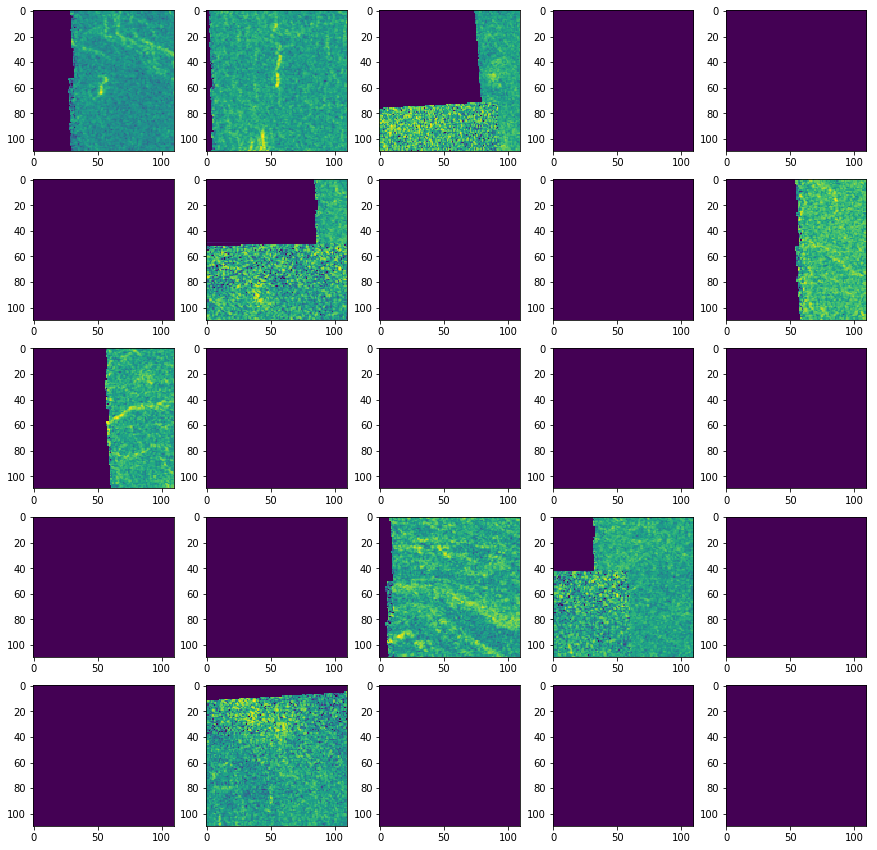

In [32]:
trainCorruptedList = corruptedImages(X_train_copy)

import random
random.shuffle(trainCorruptedList)

f, axarr = plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(X_train_copy[trainCorruptedList[i*5+j]])

Okay we can succesfully found all of them. Now we will load and fix our data again then delete corrupted images.

In [33]:
X_train = pd.read_csv('../input/volcanoes_train/train_images.csv')
y_train = pd.read_csv('../input/volcanoes_train/train_labels.csv')
X_test = pd.read_csv('../input/volcanoes_test/test_images.csv')
y_test = pd.read_csv('../input/volcanoes_test/test_labels.csv')

# Fix the column names
XFix(X_train)
XFix(X_test)

We delete corrupted images here

In [34]:
def deleteCorrupted(X, y, corruptedIndexList):
    for i in corruptedIndexList:
        X.drop(i, inplace=True) # Drop the corrupted
        y.drop(i, inplace=True) 
    
    X.reset_index(inplace=True) # Reconstruct the index
    X.drop(['index'], axis=1, inplace=True) # Delete old index column
    #Because they are pandas.series we don't need to deal with index
    #Because we use inplace=True we don't need to return something
    
trainCorruptedList = corruptedImages(X_train)
testCorruptedList = corruptedImages(X_test)

deleteCorrupted(X_train, y_train, trainCorruptedList)
deleteCorrupted(X_test, y_test, testCorruptedList)

We cleared the data but our data's shape is changed. Let's look them.

In [35]:
print("X_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

X_train -> (6791, 12100) 
y_train -> (6791, 4) 
X_test -> (2655, 12100) 
y_test -> (2655, 4)


Lastly we transform the data to make it ready for keras 

In [36]:
# Get our label
y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# One Hot Label encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

# Spliting
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Lastly resizing
X_test = np.resize(X_test, (X_test.shape[0], 110, 110, 1))
X_train = np.resize(X_train, (X_train.shape[0], 110, 110, 1))
X_val = np.resize(X_val, (X_val.shape[0], 110, 110, 1))

In [37]:
print("%70   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n%15   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n%15   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

%70   X_train -> (6791, 110, 110, 1) 
      y_train -> (6791, 2) 

%15   X_test -> (1327, 110, 110, 1) 
      y_test -> (1327, 2) 

%15   X_val -> (1328, 110, 110, 1) 
      y_val -> (1328, 2)


### b) Building and Training Improved Model With Dropouts [^](#0) <a id="11"></a> <br>

We cleaned our data and now we can start to build a new model this time we will add dropout layers.

Dropout layers will reduce the overfitting. They cut randomly the connections between nodes in layers.

<img src="https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" width="500" height="500" />

Okay let's apply them.

In [38]:
modelB = Sequential()
modelB.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (110,110,1)))
modelB.add(MaxPool2D(pool_size=(2,2)))
modelB.add(Dropout(0.5))
modelB.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same',activation ='relu'))
modelB.add(MaxPool2D(pool_size=(2,2)))
modelB.add(Dropout(0.5))
modelB.add(Flatten())
modelB.add(Dense(y_train.shape[1], activation = "sigmoid"))

In [39]:
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 110, 110, 8)       208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 55, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 27, 27, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11664)             0         
__________

We added two dropout layers. The model ready for compiling and training. In this model I also change the epoch and make it 10.

In [40]:
modelB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelB_trained = modelB.fit(X_train, y_train, batch_size=64, epochs = 10, validation_data = (X_val,y_val))

Train on 6791 samples, validate on 1328 samples
Epoch 1/10
6791/6791 [==============================] - 2s 231us/step - loss: 0.4249 - acc: 0.8542 - val_loss: 0.5047 - val_acc: 0.8245
Epoch 2/10
6791/6791 [==============================] - 1s 163us/step - loss: 0.4131 - acc: 0.8547 - val_loss: 0.5130 - val_acc: 0.8245
Epoch 3/10
6791/6791 [==============================] - 1s 168us/step - loss: 0.4124 - acc: 0.8547 - val_loss: 0.4929 - val_acc: 0.8245
Epoch 4/10
6791/6791 [==============================] - 1s 188us/step - loss: 0.4071 - acc: 0.8547 - val_loss: 0.4939 - val_acc: 0.8245
Epoch 5/10
6791/6791 [==============================] - 1s 169us/step - loss: 0.4012 - acc: 0.8547 - val_loss: 0.4725 - val_acc: 0.8245
Epoch 6/10
6791/6791 [==============================] - 1s 209us/step - loss: 0.3864 - acc: 0.8547 - val_loss: 0.4262 - val_acc: 0.8245
Epoch 7/10
6791/6791 [==============================] - 1s 171us/step - loss: 0.3602 - acc: 0.8547 - val_loss: 0.4048 - val_acc: 0.8245


And we plot our result graph:

In [41]:
trainingResultsGraph(modelB_trained, 'B')

In [42]:
scoreB = modelB.evaluate(X_test, y_test)
print('Test Loss ->', scoreB[0])
print('Test Accuracy ->', scoreB[1])

1327/1327 [==============================] - 0s 102us/step
Test Loss -> 0.23909925016453146
Test Accuracy -> 0.899020346691488


Yes new result is much better than old ones.

And also val_loss and training loss is very close to each other so there is no overfitting problem. So there is one last problem remains that we need to solve. The accuracy. Can we increase it?


## 5-Improving the Accuracy[^](#0) <a id="12"></a> <br>

Okay, we are close to building the best model. After 12 days from the beginning for me.

### a) Image Data Generator [^](#0) <a id="13"></a> <br>

Let's create a new model with some new things like ImageDataGenerator. It's provided by Keras and it does some image processing like shifting, rotation and whitening so it increases our data amount like magic.

To add this tool first, we need to import its libraries then we need to set its params. For more info [click!](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [43]:
from keras.preprocessing.image import ImageDataGenerator

dataGenerator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=False,
        vertical_flip=False)
dataGenerator.fit(X_train)

### b) More Layers and New Hyperparams [^](#0) <a id="14"></a> <br>

Finally, we can start to build the last model. In this model, we will change some hyperparameters and add some new layers.

In [44]:
modelC = Sequential()
modelC.add(Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape = (110,110,1)))
modelC.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
modelC.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu'))
modelC.add(MaxPool2D(pool_size=(2,2)))
modelC.add(Dropout(0.5))
modelC.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu'))
modelC.add(MaxPool2D(pool_size=(2,2)))
modelC.add(Conv2D(filters = 24, kernel_size = (7,7),padding = 'same',activation ='relu'))
modelC.add(Dropout(0.5))
modelC.add(Flatten())
modelC.add(Dense(y_train.shape[1], activation = "sigmoid"))

In this model we will use:

* Convolutional layer, with 2 filters of dimmension 3,3
* Convolutional layer, with 3 filters of dimmension 3,3
* Convolutional layer, with 8 filters of dimmension 5,5
* Maxpoll layer, with pool size 2,2
* Convolutional layer, with 16 filters of dimmension 5,5
* Dropout layer, wtih 0.5 drop ratio
* Maxpoll layer, with pool size 2,2
* Convolutional layer, with 24 filters of dimmension 7,7
* Dropout layer, wtih 0.5 drop ratio
* Flatten layer to transform images 2D to 1D
* Dense layer with sigmoid activation

this layers.

In [45]:
modelC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 110, 110, 2)       20        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 110, 110, 4)       76        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 8)       808       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 16)        3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 16)        0         
__________

Okay, let's compile our model and train with image data generator.

In [46]:
modelC.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelC_trained = modelC.fit_generator(dataGenerator.flow(X_train, y_train, batch_size=64), epochs=50, validation_data=[X_val, y_val], steps_per_epoch=X_train.shape[0] // 64)

Epoch 1/50
106/106 [==============================] - 7s 71ms/step - loss: 0.4303 - acc: 0.8514 - val_loss: 0.4607 - val_acc: 0.8245
Epoch 2/50
106/106 [==============================] - 7s 62ms/step - loss: 0.4245 - acc: 0.8537 - val_loss: 0.4607 - val_acc: 0.8245
Epoch 3/50
106/106 [==============================] - 7s 64ms/step - loss: 0.4163 - acc: 0.8555 - val_loss: 0.4606 - val_acc: 0.8245
Epoch 4/50
106/106 [==============================] - 7s 64ms/step - loss: 0.4149 - acc: 0.8546 - val_loss: 0.4610 - val_acc: 0.8245
Epoch 5/50
106/106 [==============================] - 7s 64ms/step - loss: 0.4140 - acc: 0.8548 - val_loss: 0.4615 - val_acc: 0.8245
Epoch 6/50
106/106 [==============================] - 7s 63ms/step - loss: 0.4108 - acc: 0.8563 - val_loss: 0.4607 - val_acc: 0.8245
Epoch 7/50
106/106 [==============================] - 7s 62ms/step - loss: 0.4151 - acc: 0.8533 - val_loss: 0.4581 - val_acc: 0.8245
Epoch 8/50
106/106 [==============================] - 7s 71ms/step - 

In [47]:
trainingResultsGraph(modelC_trained, 'C')

In [48]:
scoreC = modelC.evaluate(X_test, y_test)
print('Test Loss ->', scoreC[0])
print('Test Accuracy ->', scoreC[1])

1327/1327 [==============================] - 0s 164us/step
Test Loss -> 0.12491967511653182
Test Accuracy -> 0.9517709118311982


## 6-Conclusion [^](#0) <a id="15"></a> <br>

In [49]:
x = ['Model A', 'Model B', 'Model C']
y = [scoreA[0], scoreB[0], scoreC[0]]
y2 = [scoreA[1], scoreB[1], scoreC[1]]

trace1 = go.Bar(
    x=x,
    y=y,
    textposition = 'auto',
    name = 'Test Loss',
    marker=dict(
        color='rgb(212,123,231)',
        line=dict(
            color='rgb(155,123,244)',
            width=1.5),
        ),
    opacity=0.7
)

trace2 = go.Bar(
    x=x,
    y=y2,
    textposition = 'auto',
    name = 'Test Acc',
    marker=dict(
        color='rgb(13,22,11)',
        line=dict(
            color='rgb(200,100,240)',
            width=1.5),
        ),
    opacity=0.7
)

data = [trace1,trace2]

layout = go.Layout(
    title='Models Performance Graph',
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In conclusion, we tried to improve our results step by step and we achieve more than 0.9 accuracy in test data. 

My observations are:
* If you add dropout increase epoch because dropouts reduce and cut the momentum of training and you need more epoch to gain old results.
* Adding layer with a very high number of neurons not good. They can stuck loss rate at the same value for every epoch.
* Adding Image Data Generator also has the same effect with dropouts.
* I don't expect this acc rate. CNN works very nice for this mission.

This kernel is one my first kernel about CNN and there would be some mistakes.
Please comment if you see them or if you have a better idea about code.

Thanks for reading.